# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Название проекта: "Прогнозирование стоимости автомобилей на основе их характеристик".

Цель проекта: построить модель, которая будет предсказывать стоимость автомобиля, при этом сочетая в себе такие качества, как: скорость, точность.

На вход поступает датасет с характеристиками автомобилей, которые мы должны предварительно обработать, рассмотрев дубликаты и аномалии. Затем необходимо будет закодировать категориальные переменные и масштабировать количественные, если в этом будет необходимость.

В последствии мы будем обучать различные ансамбли, смотреть на результаты: метрику качества (корень из MSE) и скорость обучения.

Подберем гиперпараметры с помощью GSCV, проверим метрики на кросс-валидации, прежде чем работать с тестовой выборкой.

## Подготовка данных

# Предобработка данных

In [1]:
!pip install category_encoders -q

In [2]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import time
from category_encoders import TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

In [3]:
def describe_df(DataFrame):

    binary_feats = [col for col in DataFrame.columns if DataFrame[col].nunique() <= 2]
    categorical_feats = [col for col in DataFrame.columns if DataFrame[col].dtype == 'object' and col not in binary_feats]
    continuous_feats = [col for col in DataFrame.columns if DataFrame[col].dtype != 'object' and col not in binary_feats]

    print('Бинарные переменные:', binary_feats)
    print('Категориальные переменные:', categorical_feats)
    print('Количественные переменные:', continuous_feats, '\n')

    print('Количество столбцов:', DataFrame.shape[1])
    print('Количество строк:', DataFrame.shape[0], '\n')

    print('Пропуски:\n')
    print(DataFrame.isna().sum(),'\n')
    print('Дубликаты:', DataFrame.duplicated().sum(),'\n')
    print(f'\nТипы данных: \n{DataFrame.dtypes}')

    print('Описание:\n')
    display(DataFrame.describe())
    print()

    print('Dataframe начало\n')
    display(DataFrame.head())
    print()
    print('Dataframe конец\n')
    display(DataFrame.tail())

In [4]:
autos = pd.read_csv('/datasets/autos.csv')
autos.name = 'autos'

In [5]:
describe_df(autos)

Бинарные переменные: ['Gearbox', 'Repaired', 'NumberOfPictures']
Категориальные переменные: ['DateCrawled', 'VehicleType', 'Model', 'FuelType', 'Brand', 'DateCreated', 'LastSeen']
Количественные переменные: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode'] 

Количество столбцов: 16
Количество строк: 354369 

Пропуски:

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64 

Дубликаты: 4 


Типы данных: 
DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Dataframe начало



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Dataframe конец



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Видим, что в датасете 16 столбцов и 354369 наблюдений. 

Переменные распределены следующим образом:

Бинарные переменные: ['Gearbox', 'Repaired', 'NumberOfPictures']

Категориальные переменные: ['DateCrawled', 'VehicleType', 'Model', 'FuelType', 'Brand', 'DateCreated', 'LastSeen']

Количественные переменные: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'PostalCode']

Замечены пропуски в двух бинарных переменных и в трех категориальных. Также наблюдается 4 дубликата, и названия в колонок не в змеином регистре.
В планах исправить эти недочеты.

In [6]:
autos = autos.drop_duplicates().reset_index(drop=True)

In [7]:
autos['VehicleType'].value_counts()

sedan          91457
small          79830
wagon          65165
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [8]:
autos['Gearbox'].value_counts()

manual    268249
auto       66283
Name: Gearbox, dtype: int64

In [9]:
autos['Model'].value_counts()

golf                  29232
other                 24420
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
serie_1                   2
range_rover_evoque        2
Name: Model, Length: 250, dtype: int64

In [10]:
autos['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [11]:
autos['Repaired'].value_counts()

no     247158
yes     36053
Name: Repaired, dtype: int64

In [12]:
autos['Repaired'] = autos['Repaired'].fillna('no')
autos["VehicleType"] = autos["VehicleType"].fillna(autos["VehicleType"].mode().values[0])
autos["Gearbox"] = autos["Gearbox"].fillna(autos["Gearbox"].mode().values[0])
autos["Model"] = autos["Model"].fillna(autos["Model"].mode().values[0])
autos["FuelType"] = autos["FuelType"].fillna(autos["FuelType"].mode().values[0])

In [13]:
autos.columns = autos.columns.str.lower()

In [14]:
autos = autos.rename(columns={'datecrawled':'date_crawled', 
                        'vehicletype':'vehicle_type', 
                        'registrationyear':'registration_year', 
                        'registrationmonth':'registration_month', 
                        'fueltype':'fuel_type', 
                        'datecreated':'date_created',
                        'numberofpictures': 'number_of_pictures',
                        'postalcode':'postal_code',
                        'lastseen':'last_seen'})

In [15]:
describe_df(autos)

Бинарные переменные: ['gearbox', 'repaired', 'number_of_pictures']
Категориальные переменные: ['date_crawled', 'vehicle_type', 'model', 'fuel_type', 'brand', 'date_created', 'last_seen']
Количественные переменные: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'postal_code'] 

Количество столбцов: 16
Количество строк: 354365 

Пропуски:

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64 

Дубликаты: 1 


Типы данных: 
date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object


,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000



Dataframe начало



,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,golf,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21



Dataframe конец



,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
354360,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354361,2016-03-14 17:48:27,2200,sedan,2005,manual,0,golf,20000,1,petrol,sonstige_autos,no,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354362,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354363,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354364,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,no,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


Предобработка данных завершена, дубликаты удалены, пропуски заполнены модальными значениями.

Удаление пропусков было бы некорректным, так как их было чересчур много.

# Исследовательский анализ

In [16]:
autos = autos.drop(["date_crawled","date_created","last_seen","number_of_pictures","postal_code", "registration_month"],axis = 1)

Удаляем неинформативные переменные, так как они будут мешать обучению

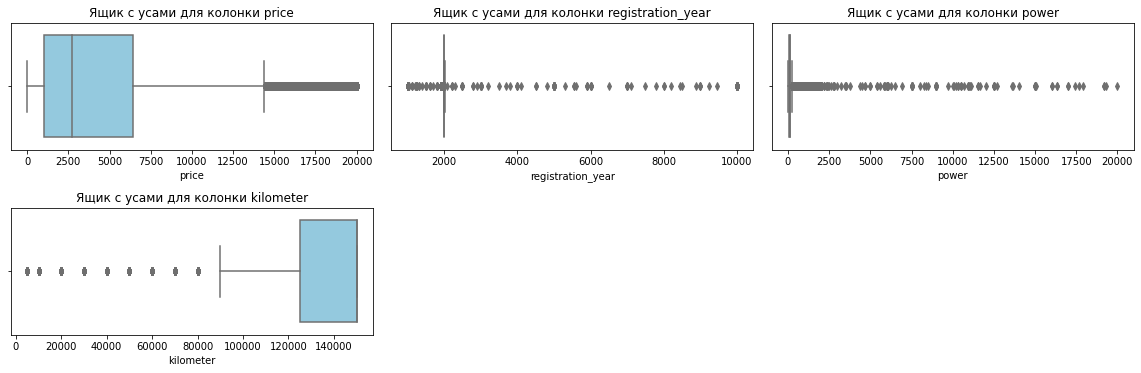

In [17]:
numerical_columns = ['price', 'registration_year', 'power', 'kilometer', 'registration_month']

plt.figure(figsize=(16, 10))

for i, column in enumerate(numerical_columns, 1):
    if column in autos.columns:
        plt.subplot(4, 3, i)
        sns.boxplot(x=autos[column], color='skyblue')
        plt.title(f'Ящик с усами для колонки {column}')
        plt.xlabel(column)

plt.tight_layout()
plt.show()

Очевидно большое количество аномалий в количественных переменных, также в колонке registration_month почему-то фигурирует число 0.

Для начала избавимся от черечур мощных значений лошадиных сил в двигателе, также можем обработать значения в колонке с датой регистрации.

In [18]:
autos = autos.loc[(autos['registration_year'] <= 2016) & (autos['registration_year'] >= 1900)]

In [19]:
autos = autos.loc[autos['power'] <= 1000]

In [20]:
autos = autos.loc[autos['price'] > 0]

In [21]:
autos['fuel_type'] = autos['fuel_type'].replace(['gasoline'],'petrol')

In [22]:
describe_df(autos)

Бинарные переменные: ['gearbox', 'repaired']
Категориальные переменные: ['vehicle_type', 'model', 'fuel_type', 'brand']
Количественные переменные: ['price', 'registration_year', 'power', 'kilometer'] 

Количество столбцов: 10
Количество строк: 329499 

Пропуски:

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64 

Дубликаты: 54900 


Типы данных: 
price                 int64
vehicle_type         object
registration_year     int64
gearbox              object
power                 int64
model                object
kilometer             int64
fuel_type            object
brand                object
repaired             object
dtype: object
Описание:



,price,registration_year,power,kilometer
count,329499.000000,329499.000000,329499.00000,329499.000000
mean,4608.182307,2002.594648,108.68538,128207.566639
std,4546.889190,6.927703,63.38386,37518.805410
min,1.000000,1910.000000,0.00000,5000.000000
25%,1200.000000,1999.000000,71.00000,125000.000000
50%,2900.000000,2003.000000,105.00000,150000.000000
75%,6600.000000,2007.000000,143.00000,150000.000000
max,20000.000000,2016.000000,1000.00000,150000.000000



Dataframe начало



,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,golf,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no



Dataframe конец



,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
354359,1150,bus,2000,manual,0,zafira,150000,petrol,opel,no
354361,2200,sedan,2005,manual,0,golf,20000,petrol,sonstige_autos,no
354362,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354363,9200,bus,1996,manual,102,transporter,150000,petrol,volkswagen,no
354364,3400,wagon,2002,manual,100,golf,150000,petrol,volkswagen,no


Исследовательский анализ завершен, осталось около 330 тысяч строк, 10 колонок.

## Обучение моделей

In [23]:
categorical_cols = ['vehicle_type', 'gearbox', 'fuel_type', 'brand', 'model', 'repaired']

In [24]:
X = autos.drop('price', axis=1)
y = autos['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [25]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [26]:
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [27]:
rf_pipeline = Pipeline([
    ('encoder', TargetEncoder(cols=categorical_cols)),
    ('model', RandomForestRegressor(random_state=42))
])

In [28]:
lgb_encoder = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_cols)
])
lgb_pipeline = Pipeline([
    ('encoder', lgb_encoder),
    ('model', lgb.LGBMRegressor(random_state=42))
])


In [29]:
cat_pipeline = Pipeline([
    ('encoder', FunctionTransformer(lambda x: x, validate=False)),
    ('model', CatBoostRegressor(random_state=42, verbose=0, cat_features=categorical_cols))
])

In [30]:
param_grid_rf = {
    'encoder__smoothing': [1, 5, 10],  # регуляризация при кодировании
    'model__n_estimators': [50, 100],
    'model__max_depth': [10, None]
}

In [31]:
grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    scoring=rmse_scorer,
    cv=5,
    n_jobs=-1,
    refit=True,
    verbose=1
)

In [32]:
start_time = time.time()
grid_rf.fit(X_train, y_train)
rf_tuning_time = time.time() - start_time

print(f"\nВремя подбора гиперпараметров для RandomForest: {rf_tuning_time:.2f} сек")
print("Лучшие параметры для RF:", grid_rf.best_params_)
best_rf_cv_score = abs(grid_rf.best_score_)
print(f"Лучшая средняя RMSE (CV) для RF: {best_rf_cv_score:.2f}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Время подбора гиперпараметров для RandomForest: 1689.44 сек
Лучшие параметры для RF: {'encoder__smoothing': 5, 'model__max_depth': None, 'model__n_estimators': 100}
Лучшая средняя RMSE (CV) для RF: 1645.19


In [33]:
best_rf_pipeline = grid_rf.best_estimator_

In [34]:
def evaluate_pipeline(pipeline, X, y, cv=5):
    cv_results = cross_validate(
        pipeline,
        X,
        y,
        scoring=rmse_scorer,
        cv=cv,
        return_train_score=False,
        n_jobs=-1
    )
    mean_rmse = abs(cv_results['test_score'].mean())
    mean_fit_time = cv_results['fit_time'].mean()
    mean_score_time = cv_results['score_time'].mean()
    return mean_rmse, mean_fit_time, mean_score_time

In [35]:
rf_cv_rmse, rf_cv_fit_time, rf_cv_score_time = evaluate_pipeline(best_rf_pipeline, X_train, y_train)
lgb_cv_rmse, lgb_cv_fit_time, lgb_cv_score_time = evaluate_pipeline(lgb_pipeline, X_train, y_train)
cat_cv_rmse, cat_cv_fit_time, cat_cv_score_time = evaluate_pipeline(cat_pipeline, X_train, y_train)

## Анализ моделей

In [36]:
results_summary = pd.DataFrame({
    'Model': ['RandomForest (TargetEncoder)', 'LightGBM (OneHotEncoder)', 'CatBoost (Identity)'],
    'CV Mean RMSE': [rf_cv_rmse, lgb_cv_rmse, cat_cv_rmse],
    'CV Mean Fit Time (sec)': [rf_cv_fit_time, lgb_cv_fit_time, cat_cv_fit_time],
    'CV Mean Score Time (sec)': [rf_cv_score_time, lgb_cv_score_time, cat_cv_score_time]
})
print("\nСводная таблица результатов кросс-валидации:")
display(results_summary)


Сводная таблица результатов кросс-валидации:


,Model,CV Mean RMSE,CV Mean Fit Time (sec),CV Mean Score Time (sec)
0,RandomForest (TargetEncoder),1645.192385,45.034978,2.033121
1,LightGBM (OneHotEncoder),3584.687418,6.038776,0.958535
2,CatBoost (Identity),1666.250950,142.069715,0.337421


In [37]:
start_time = time.time()
best_rf_pipeline.fit(X_train, y_train)
final_fit_time = time.time() - start_time

In [38]:
start_time = time.time()
y_pred_test = best_rf_pipeline.predict(X_test)
final_pred_time = time.time() - start_time
final_rmse = rmse(y_test, y_pred_test)

In [39]:
print("\n--- Итоговая оценка на тестовой выборке для RF (TargetEncoder) ---")
print(f"Время дообучения: {final_fit_time:.2f} сек")
print(f"Время предсказания: {final_pred_time:.4f} сек")
print(f"Test RMSE: {final_rmse:.2f}")


--- Итоговая оценка на тестовой выборке для RF (TargetEncoder) ---
Время дообучения: 56.26 сек
Время предсказания: 3.2668 сек
Test RMSE: 1603.04


# Итоговый вывод: 

Были загружены и предобработаны данные по характеристикам автомобилей.
Удалены дубликаты, пропуски заполнены модальными значениями, удалены неинформативные переменные, такие как: месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты (пользователя), дата последней активности пользователя.

Категориальные переменные были закодированы с помощью OHE, Target Encoder.
С учётом сочетания качества (RMSE) и времени обучения/предсказания лучшей моделью в данном эксперименте оказалась Random Forest. Она даёт почти самую низкую ошибку на кросс-валидации(около 1645) и при этом тренируется быстрее остальных, несмотря на достаточно долгий подбор гиперпараметров.
